# House Price Prediction in Pittsburgh

### Motivation and Objectives

A home is often the largest and most expensive purchase a person makes in his or her lifetime. The house prices of a city can ususally reflects the economic condition to some extend. Moreover, house prices trends are always a concern of as an asset investment for buyers. Therefore, as data scientist, creating a decent house price prediction model can help people to make decision in making house investment. 

Unlike other house price prediction model, our model collects data from multiple resources, including trulia.com, which is a home and neighborhood website that offers buyers and renters detailed information related to the house on sell. In addition, We also collect data from YELP about the restaurant nearby a given house as well as the walkscore date of walkability, availability of transit and bike are also collected from the walk score API. 



### Table of Content:

1. [Data Collection](#Data-Collection)
2. [Dataset Description](#Dataset-Description)
3. [Data Cleaning](#Data-Cleaning)
4. [Exploratory Data Analysis](#Exploratory-Data-Analysis)
5. [Data Preprocessing](#Data-Preprocessing)
6. [Predictive Model](#Predictive-Model)
7. [Conclusion](#Conclusion)
8. [Limitation and Future Work](#Limitation-and-Future-Work)
9. [Reference](#Reference)

### Import Libraries

In [229]:
import pandas as pd
import io, time, json
import requests
from pathlib import Path
from bs4 import BeautifulSoup
import numpy as np
import random
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm, skew
from scipy import stats
import pandas_profiling as pp
import warnings
warnings.filterwarnings('ignore')
from scipy.special import boxcox1p
import re
import folium
from folium.plugins import HeatMap
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import warnings
warnings.filterwarnings('ignore')
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.cross_validation import KFold
import matplotlib; matplotlib.use('TkAgg')
import lightgbm as lgb

## Data Collection

The dataset for this project is mainly collected from three sources, Trulia.com, Yelp API and WalkScore.com. In order to get recent transaction of property sold in Pittsburh, a list of properties sold within 9 month is scraped from trulia websearch page. We believe that the property value is closely related to the the walkability of the neighborhoods. That is, a walkable neighborhoods with high accessibility to quality public transit, civic and community facilities and services tend to raise property value. With this purpose, we collect relavant neiborhood information from WalkScore and Yelp API. The data collection pipeline is shown in blow figure.




<img src="./img/data_collection2.jpg" alt="Drawing" style="width: 600px;"/>

When we scrape data from trulia and walkscore webpages, we used `agent` and `time.sleep()` to pretend human users and avoid being denied from accessing. It takes too long to run the whole data block related to data collection. To better illustrate the process, we will use an example from the dataset to walk you through the process. The code we used for scraping the data will also be provided at each step.

#### Step 1 - Scrape property sold transaction list from Trulia
The first step is to scrape a list of houses in Pittsburgh that were sold in the last 9 months. Since we used `time.sleep()` to pretend we are human users, it takes too long to run the whole block of code we used in this step. Please check [`data_collection_trulia_list.py`](./code/data_collection_trulia_list.py) for detailed code of this step. We restrict the property sold transaction within the last 9 months. Below is an example, it is one of the data entries we scraped from Trulia. We will use the example in the following steps. 

| street_address | postal_code | latitude | longitude | link | page | num | address_locality | address_region | scrape_generated | link_generated | is_same | property |
| --- |:---:|:--- |: --- |:---:|:--- |: --- |:---:|:--- |: --- |:---:|:--- |: --- |
|701 Amberson Ave |	15232 |	40.450714 |	-79.94018 |	https://www.trulia.com/p/pa/pittsburgh/701-amberson-ave-pittsburgh-pa-15232--2014230510 | 160 | 15 | Pittsburgh | PA | 701 amberson ave pittsburgh pa 15232 | 701 amberson ave pittsburgh pa 15232 | 1 | 0 |


Some of the houses have different format than others in the html content, which makes the output csv not we expected. We select these entries, check the information and input the correct information manually. The output is stored as a csv file. Please refer to [`scrape_trulia_list.csv`](./scrape_data/scrape_trulia_list.csv) in the "scrape" folder for detailed information.

#### Step 2 - Scrape data from Yelp
Once we get latitude and longitude of the house from step 1, we can collect nearby restaurant, art and entertainment, as well as grocery information for each property from Yelp through making authenticated HTTP request to the Yelp API business search endpoint. The query passed to API request include `latitude` and `longitude` of the property, search `radius` and the `category` for business search.  
The data we collected from Yelp are
 * number of restaurant nearby
 * average rating of restaurant nearby
 * average price level of restaurant nearby
 * number of art and entertainment services nearby
 * number of grocery store nearby

Some example code to get data from Yelp API is shown in below block.  Please check [`scrape_yelp&walkscore.py`](./code/dscrape_yelp&walkscore.py) for detailed code of this step. 

In [230]:
# source code from course homework
# Args: url (string):
# Returns: status_code (integer), raw_html (string)
def retrieve_html(url):
   
    response = requests.get(url)
    status = response.status_code
    content = response.text
    
    return (status, content)

def read_api_key(filepath=r"./scrape_data/api_key_clear.txt"):
    return Path(filepath).read_text().strip()

# Make an authenticated request to the Yelp API, modified from 
# Args:  query (tuple): (latitude, longitude, radius, category)
# returns: total (integer): total number of businesses on Yelp corresponding to the query 
#          businesses (list): list of dicts representing each business

def yelp_search(api_key, query):
        
    header =  {'Authorization': 'Bearer '+ api_key}
    url = "https://api.yelp.com/v3/businesses/search"
    searchKey = dict()
    
    
    lat, long, radius, cat = query
    
    searchKey["latitude"] = lat
    searchKey["longitude"] = long
    searchKey["radius"] = radius
    searchKey["categories"] = cat
    
    searchKey["sort_by"] = "distance"
    searchKey["location"] = "Pittsburgh"
    
    response = requests.get(url, params=searchKey, headers=header)
     
    
    business = []
    
    responseDict = json.loads(response.text)
    
    if "businesses" in responseDict:
        business = responseDict["businesses"]
        
    total = responseDict["total"]
    
    return total, business

# Get average rating and price level of business list
# Args: total: total (integer): total number of businesses
#       businesses (list): list of dicts representing each business
# Returns: average_rating(float), average_price(float)
def get_average(total, business):
    
    ratings = 0
    prices = 0
    rating_count = 0
    price_count = 0
    res_rating = 0
    res_price = 0
    
    for res in business:

        if "rating" in res:
            rating = res["rating"]
            ratings += rating
            rating_count += 1
        
        
        if "price" in res:
            price = res["price"]
            prices += len(price)
            price_count += 1
            
    if rating_count != 0:
        res_rating = ratings / rating_count
        
    if price_count != 0:
        res_price = prices / price_count
    
    if total == 0:
        return 0, 0
        
    return res_rating, res_price

In below block, we use an example to illustrate the content we scrape from yelp.

In [231]:
df = pd.read_csv(r"./scrape_data/scrape_trulia_list.csv")
item = df[df["street_address"] == "701 Amberson Ave"]
lat, long, url = item["latitude"], item["longitude"], item["link"]
query_restaurant = (lat, long, 1000, "restaurants")
query_art = (lat, long, 1500, "arts")
query_grocery = (lat, long, 1500, "grocery")
total_restaurant, business_restaurant = yelp_search(read_api_key(), query_restaurant)
average_rating, average_price = get_average(total_restaurant, business_restaurant)
total_art, business_art = yelp_search(read_api_key(), query_art)
total_grocery, business_grocery = yelp_search(read_api_key(), query_grocery)
print("number of restaurant nearby: %d " %total_restaurant)
print("average rating of restaurant nearby: %0.1f " %average_rating)
print("average price level of restaurant nearby: %0.1f " %average_price)
print("number of art and entertainment nearby: %d " %total_art)
print("number of grocery nearby: %d " %total_grocery)

number of restaurant nearby: 92 
average rating of restaurant nearby: 3.6 
average price level of restaurant nearby: 1.5 
number of art and entertainment nearby: 46 
number of grocery nearby: 13 


#### Step 3 - Scrape scores from WalkScore
The next step is to retrive walkability, transit accessibility and bike accessibility of corresponding location from WalkScore webpage. We then generate corresponding WalkScore url for each property using property street address and scrape scores from webpage badges. The code block below shows some base function we use to scrape score,  Please check [`scrape_yelp&walkscore.py`](./code/dscrape_yelp&walkscore.py) for detailed code of this step. 

In [232]:
# Generate link to corresponding walkscore webpage according to a house's trulia link
# Args: link(string): trulia link of the house
# Return: url(string): url of corresponding walkscore page for the house
def get_url(link):
#     link = link.to_string()
#     print(link)
    link.reset_index(inplace=True, drop=True)
    walkscore_path = "https://www.walkscore.com/score/"
    temp = "-".join(link[0].split("/")[-1].split("-")[:-2])
    url = walkscore_path + temp
    return url

#  Scrape walk, bike and transit score from webpage
# Args: url(string): url of walkscore page for a house
# Returns: score(dict): dictonary stores walk, bike and transit score for the house
def get_score(url):
    agent = {"User-Agent":'Mozilla/5.0 (Windows NT 6.3; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/59.0.3071.115 Safari/537.36'}
    page = requests.get(url, headers=agent)
    root = BeautifulSoup(page.content, "html.parser")
    content = root.find_all("img")

    score = dict()
    
    for img in content:
        src = img.get("src")
        alt = img.get("alt")
        
        if src != None and src.startswith("//pp.walk.sc/badge/"):
            name = src.split("/")[-3].lower()
            s = src.split("/")[-1].split(".")[0].lower()
            score[name] = s
        if len(score) == 3:
            break
    return score

ws_url = get_url(url)
score = get_score(ws_url)
print("Scores for 701 Amberson Avenues: %s" %score)

Scores for 701 Amberson Avenues: {'walk': '78', 'transit': '69', 'bike': '53'}


#### Step 4:
The following images is one of the data sample, highlighted with the features that are collected specifically for this project.

<img src="./img/datacollec1.png" alt="Drawing" style="width: 600px;"/>

We start off by performing some web crawling that extracts specficd data of the html pages from trilia.com, yelp fusion API and walk.score.com. The data collecting by web crawlling process is a trivial and tedious process, because you can easily get "access denied" if you crawling too frequently. In order to resolve the issue, we use a crawler user agent "Mozilla/5.0 (Windows NT 6.3; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/59.0.3071.115 Safari/537.36" and request a url page with a time sleep of 100 miliseconds to avoid too frequent web request. Even such, we can only collect 1000-1500 per day. Finally, all data collects from the 3 resources are aggregated into one csv file for subsequent model training.  

In [233]:
# Reads one address of a house and its corresponding url of trilia page.
def getLinks(path):
    df = pd.read_csv(path)
    df = pd.DataFrame(df, columns= ['streetAddress', 'link'])
    address_link_lst = [df.columns.values.tolist()] + df.values.tolist()  # len 2605, included column header
    return address_link_lst

# For each address nspect the html page, inspect its html elements and extract targeted information using the corresponding class name and attribute names.
def getSoup(url):
    agent = {"User-Agent":'Mozilla/5.0 (Windows NT 6.3; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/59.0.3071.115 Safari/537.36'}
    page = requests.get(url, headers=agent)
    root = BeautifulSoup(page.content, "html.parser")
        
    content_json = root.find_all(type="application/ld+json")
    
    content_div = root.find_all('div', class_="MediaBlock__MediaContent-ldzu2c-1 bumWFt")
    
    content_mortage = root.find_all('div', class_="Text__TextBase-sc-1i9uasc-0-div Text__TextContainerBase-sc-1i9uasc-1 dkumKO")

    content_homeDetail = root.find_all('li', class_="FeatureList__FeatureListItem-iipbki-0 dArMue")

    content_priceTrends = root.find_all('div', class_="MediaBlock__MediaContent-ldzu2c-1 hWgsUV")
    
    content_price_and_mtg = root.find_all('div', class_="Text__TextBase-sc-1i9uasc-0-div Text__TextContainerBase-sc-1i9uasc-1 gtxlcQ")
    
    return page, content_json, content_div, content_mortage, content_homeDetail, content_priceTrends, content_price_and_mtg

# first store the html contents locally, this is makes it more convience to naviagte information and retrieve class and divisions
def storeSoup(url, outputF, printFlag):
    agent = {"User-Agent":'Mozilla/5.0 (Windows NT 6.3; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/59.0.3071.115 Safari/537.36'}
    page = requests.get(url, headers=agent)
    root = BeautifulSoup(page.content, "html.parser")
    root = root.prettify()
    if printFlag == True:
        print(root)
    else:
        with open(outputF, "w", encoding='utf-8') as file:
            file.write(str(root))


This code block shows the detailed information and data we crawl from one example page of trilia.com

In [234]:
# get sold price of house sold
def price(content_div):
    for div in content_div: 
        res = re.sub('[^0-9]','', div.text)
        return res

# get number of beds, number of baths, floor area
def bedsBathsArea(content_div):
    res = {"nBeds": 0, "nBaths": 0, "area": 0}
    for div in content_div: 
        s = [i for i in div.text.split()]
        if "Beds" in s:
            res["nBeds"] = s[0]
        if "sqft" in s:
            res["area"] = s[0]
        if "Baths" in s or "Bath" in s:
            res["nBaths"] = s[0] 
    return res

def mortage(content_mortage):
    i = 0
    res = []
    for div in content_mortage:
        res.append(div.text)
        i += 1
        if i == 2:
            return res

    
def homeDetails(content_homeDetail):
    res = dict()
    for div in content_homeDetail:
        s = div.text
        if s.find(":") != -1:
            elem = s.split(":")
            res[elem[0]] = elem[1][1:] # remove white space
        else:
            res[s] = ""
    res1 = [[i, v] for i, v in res.items()]
    for i in res1:
        for j in i:
            if j == "":
                i.remove(j)
    return res1 

# get home detials table from html page, format and clean the format to be stored in csv file
def cleanHomeDetails(content_homeDetail):
    res = homeDetails(content_homeDetail)
    res1 = dict()
    bldgtype = ["Townhouse", "Multi Family", "Single Family Home", "Condo"]
    withComa = ["Lot Size", "Cooling System", "Heating", "Heating Fuel", "Stories", "Parking", "Exterior", "Roof", "Parking Spaces"]
    for i in ["Dishwasher", "Microwave", "Washer", "Dryer", "Refrigerator"]:
        res1[i] = 0
    for i in range(len(res)):
        if (len(res[i]) == 2) and (res[i][0] in withComa):
            key = res[i][0].lower()
            res1[key] = res[i][1]
            
        if (len(res[i]) == 1):
            elem = res[i][0]
            if elem == "Dishwasher":
                res1["Dishwasher"] = 1
            if elem == "Microwave":
                res1["Microwave"] = 1
            if elem == "Washer":
                res1["Washer"] = 1
            if elem == "Dryer":
                res1["Dryer"] = 1
            if elem == "Refrigerator":
                res1["Refrigerator"] = 1
            if "Built" in elem:
                res1["Built in year"] = elem.split()[-1]
            if "Rooms" in elem:
                res1["Number of rooms"] = elem.split()[0]
            if "Architecture" in elem:
                res1["Architecture type"] = elem.split()[0]
            if elem in bldgtype:
                res1["Building type"] = elem
    if "stories" in res1.keys():
        tmp = res1["stories"].split()
        if (len(tmp) > 1):
            res1["stories"] = tmp[0]
    return res1

# parse and obtain table elements using xpath
def getTables(page): 
    doc = lh.fromstring(page.content)
    # parse content between <tr>..</tr> of HTML
    tr_elements = doc.xpath('//tr')
    table_price_hist = dict()
    table_property_tax = dict()
    
    # price history table
    try: 
        for t in zip(tr_elements[0], tr_elements[1]):
            name = t[0].text_content()
            table_price_hist[name] = t[1].text_content()
            
        # property tax table
        for i in range(3, 9):
            for t in range(len(tr_elements[i])):
                k = tr_elements[i][t].text_content()
                if (t%2 == 0) and (t+1 < len(tr_elements[i])):
                    table_property_tax[k] = tr_elements[i][t+1].text_content()
    except:
        return {}, {}
    return table_price_hist, table_property_tax

# flatten json object using recursion and nested function to the get information at the deepest level
def flatten_json(json_str):
    res = dict()
   
    def flatten(x, name=''):
        if isinstance(x, dict):
            for a in x.keys():
               # use -> to append sub-key
                flatten(x[a], name + a + '->')
        elif isinstance(x, list):
            for i in range(len(x)):
                index = str(i)
                flatten(x[i], name + index + '->')
        else:
           # otherwise, return original
            res[name[:-2]] = x
    # called the inner nested function
    flatten(json_str)
    return res


After retrieving data from each section of the html page, we then aggregate the results are stored them into dataframe using the Python data analysis library: panda, and output the dataframe as csv file to be stored locally.

In [235]:
# aggregate result for one address
def resultAggre(addr, url):
    page, content_json, content_div, content_mortage, content_homeDetail, content_priceTrends, content_price_and_mtg = getSoup(url)
    prc = price(content_price_and_mtg)
    bba = bedsBathsArea(content_div)
    mtg = mortage(content_mortage)
    hmdetail = cleanHomeDetails(content_homeDetail)
    
    res = {"address": addr, "link": url, "beds": bba["nBeds"], "baths": bba["nBaths"], "area": bba["area"], "sold information": mtg}
    for k, v in hmdetail.items():
        res.update({k: v})
    res.update({"price": prc})
    return res

addr = "701 Amberson Ave"
url = "https://www.trulia.com/p/pa/pittsburgh/701-amberson-ave-pittsburgh-pa-15232--2014230510"
res = resultAggre(addr, url)
print(res)

{'address': '701 Amberson Ave', 'link': 'https://www.trulia.com/p/pa/pittsburgh/701-amberson-ave-pittsburgh-pa-15232--2014230510', 'beds': '4', 'baths': '3.5', 'area': '2,400', 'sold information': ['Last Sold: May 8, 2019', '11% below list $1.38M'], 'Dishwasher': 0, 'Microwave': 0, 'Washer': 0, 'Dryer': 0, 'Refrigerator': 0, 'Building type': 'Single Family Home', 'lot size': '7,397 sqft', 'Built in year': '1900', 'Number of rooms': '9', 'heating': 'Other', 'heating fuel': 'Gas', 'cooling system': 'Central', 'parking': 'Attached Garage', 'parking spaces': '2', 'Architecture type': 'Tudor', 'stories': '2', 'exterior': 'Stucco', 'roof': 'Shake Shingle', 'price': '1240000'}



#### Step 5:
After we successfully get all the data we need for the analysis, we first need to put all the inforamtion together. We did that by parsing the csv files as dataframes, join them into a larger dateframe based on the "address" and output as a csv file. Please refer to [data.csv](./scrape_data/data.csv) for detailed information.

In [236]:
trulia_file = r"./scrape_data/trulia_information.csv" 
yelp_ws_file = r"./scrape_data/yelp_ws_information.csv"

trulia = pd.read_csv(trulia_file, thousands=",")
yelp_ws = pd.read_csv(yelp_ws_file)
df = trulia.merge(yelp_ws, on = ["address"], how = 'left')
df.to_csv(r"./scrape_data/data.csv",index = False)

Now all the information are stored in the csv file "data.csv". We can first have a summary of the dataframe.

In [237]:
pp.ProfileReport(df)

Number of variables,36
Number of observations,6311
Total Missing (%),12.8%
Total size in memory,1.8 MiB
Average record size in memory,296.0 B
Numeric,17
Categorical,11
Boolean,4
Date,0
Text (Unique),2
Rejected,2


## Dataset Description

The dataset consists 6045 instances, each row respresents a property in Pittsburgh. The goal is to predict the sold price of the property based on !!!! numerical features and !!!!! categorical features. The features are:

| Column | Type | Description |
| --- |:---:|:--- |
| address | categorical | street address of the house |
| postcode | categorical | zipcode of the property |
| latitude | continnuous | |
| longitude| continnuous | |
| link | - | trulia link of the property |
| home_type | categorical | `House`, `Condo`, `Townhouse`, `Multi-family`|
| architecture_type | categorical | `Colonial`, `Craftsman`, `CapeCod`, `Ranch`, `Victorian`, `Contemporary`, `SplitLevel`, `Tudor`, `Bungalow`, `Modern`, `French`, `Georgian`, `Loft`, `Multi` |
| stories | caregorical | `1`, `2`, `3`, `4`, `9`, `split`, `bi-level`|
| number_of_beds | continuous | number of bedroom in the house |
| number_of_baths | continuous | number of bathroom in the house |
| area | continuous | floor area of the house |
| lot_size | continuous | lot size of the property |
| built_year | continuous | built in year of the property |
| number_of_rooms | continuous | number of rooms |
| parking | categorical | `Attached garage`, `Detached garage`, `Off Street parking`, `On Street parking`, `Garage lot` |
| parking_space| continuous | number of parking space |
| exterior | categorical | `Vinyl`, `Brick`, `Wood`, `Brick Stone Vinyl`, `Brick Vinyl`, `Stone Vinyl`, `Stone Stucco`, `Cement Concrete Wood`, `Cement Concrete`, `Brick Wood`, `Brick Cement Concrete Stucco`, `Metal`, `Brick Cement Concrete`, `Stone`, `Brick Stone`, `Other`, `Rock, Stone`, `Masonry`, `Vinyl Wood`, `Cement Concrete Stucco`, `Stucco`, `Brick Metal`, `Brick Cement Concrete Vinyl`, `Cement Concrete Vinyl`, `Concrete Block`, `Shingle Vinyl`, `Brick Stone Stucco Wood`, `Wood Wood Products`, `Brick Stone Wood`, `Construction Brick`, `Brick Stucco`, `Composition Stone`, `Brick Metal Vinyl Wood Products`, `Metal Stone`, `Concrete`, `Brick Vinyl Wood`, `Shingle`, `Brick Metal Wood` |
| dishwasher | categorical | has dishwasher or not |
| microwave | categorical | has microwave or not |
| dryer | categorical | has dryer or not |
| washer | categorical | has washer or not |
| refrigerator | categorical | has refrigerator or not |
| heating_system | categorical | `Baseboard`, `Central`, `Electric`, `Forced air`, `Gas`, `Heat pumpa`, `Radiant`, `Wall`, `Other` | 
| heating_fuel | categorical | `Electric`, `Gas`, `Natural gas`, `Oil`, `Solar`, `Other` |
| cooling_system | categorical | `Central`, `Solar`, `Wall`, `None` |
| roof | categorical | `Asphalt`, `Shake Shingle`, `Slate', 'Composition`, `Shingle (Not Wood)`, `Metal`, `Tile`, `Roll Composition`, `Built Up`, `Roofing Asphalt`, `Slate Roof`, `Asphalt Roof` |
| restaurant_count | continuous | number of nearby restaurant | 
| restaurant_rating | continuous | average rating of nearby restaurant | 
| restaurant_price | continuous | average price level of nearby restaurant |
| arts_count | continuous | number of art and entertainment business nearby |
| grocery_count | continuous | number of groceries nearby |
| walk | continuous | walk score at the property location |
| transit | continuous | transit score at the property location |
| bike | continuous | bike score at the property location |
| price | continuous |latest sold price of the property |

## Data Cleaning
For data cleaning process, steps are as following:
1. Remove rows with missing important feature and unrealistic feature 
2. Format unstructed column
2. Drop features with high percentage of missing values (NAN)
3. Handle remain NAN values
    * Categorical feature: replace nan value with type "None" or "Unknown"
    * Numerical feature: replace nan value with median value or fitted value
4. Remove outliters
5. Map datatype
6. Reset index

Let's take a look at percentage of missing value for each feature first.

In [238]:
df = pd.read_csv(r"./scrape_data/data.csv", thousands=",")
pd.isna(df).sum() / len(df) * 100

address               0.000000
link                  0.000000
number_beds           0.000000
number_baths          0.000000
area                  0.000000
sold information      0.000000
dishwasher            0.000000
microwave             0.000000
washer                0.000000
dryer                 0.000000
refrigerator          0.000000
building_type         0.000000
lot_size             12.565362
built_year            0.332752
number_of_rooms      23.577880
heating_system       15.148154
heating_fuel         62.097924
cooling_system       44.984947
parking              47.187450
parking_spaces       46.537791
architecture_type    55.062589
stories              38.979559
exterior             34.923150
roof                 22.975757
price                 2.392648
postcode              0.000000
latitude              0.000000
longitude             0.000000
restaurant_count      0.000000
restaurant_rating     0.000000
restaurant_price      0.000000
arts_count           12.200919
grocery_

Since property sold price is our target and built in year has very small percentage of missing value, we remove rows with no price and built in year information. Since the floor are must be greater than zero, rows with floor area smaller than zero are also dropped.

In [239]:
# drop rows with missing price and built year
df = df[(pd.notna(df.price))]
df = df[(pd.notna(df.built_year))]
df = df[df['area'] > 0]

In original dataset, units (sf, acre) are included in the lot size column. Hence, we need to format lot size column and covert into universal unit.

In [240]:
# This function remove unit in lot size column and change all unit to squarefeet.
def conver_lotsize(df):
    res = []
    for i in df["lot_size"]:
        if isinstance(i,float):
            res.append(i)
            continue
        ii = i.split(" ")
        if  ii[-1] == 'acres' or ii[-1] == 'acre':

            t = ii[0]
            r = "".join(t.split(","))
            res.append(43560 * float(r))
            continue
        if ii[-1] == 'sqft':
            t = ii[0]
            r = "".join(t.split(","))
            res.append(float(r))
        else:
            res.append(i)
    df["lot_size"] = res
    return df

df = conver_lotsize(df)


Then, useless features such as `address`, `link`, and `sold information` are removed from dataset. In addition, features with high percentage of missing values (nan) such as `heating_fuel`, `architecture_type`, `exterior`, `bike`, `number_of_rooms`, `parking_spaces`, `roof` are dropped here.

In [241]:
drop_list = ["address", "link", "sold information","heating_fuel","architecture_type", "exterior", "bike", "number_of_rooms", "parking_spaces", "roof"]
df = df.drop(drop_list, axis = 1)

The next step is to handle remaining nan values for each feature. Categorical features like `cooling_system`, `heating_system` and `parking`, we reasonablely assume the property does not have these features if these information are not listed in website. Hence, the missing values for these three features are replaced with `None` tag. As for `stories`, the missing values are replaced with `Unknown` tag.


In [242]:
df["cooling_system"].fillna("None", inplace = True)
df["heating_system"].fillna("None", inplace = True)
df["parking"].fillna("None", inplace = True)
df["stories"].fillna("Unknown", inplace = True)


Countinuous numerical features such as `lot_size` and `walk`, missing values are replaced with `median`. As for `arts_count` and `grocery_count`, missing values are filled with `zeros` which means there is no art and entertainment services and grocery store nearby.


In [243]:
lotsize_mean = df[df["lot_size"] != -1]["lot_size"].median()
df["lot_size"].fillna(lotsize_mean, inplace = True)
df["walk"].fillna(df.walk.median(), inplace = True)
df["arts_count"].fillna(0, inplace = True)
df["grocery_count"].fillna(0, inplace = True)

Here, properties with sold price falling outside plus and minus 3 standard deviations range are considered as outliers.

In [244]:
df = df[np.abs(df.price - df.price.mean()) <= (3 * df.price.std())]

Finally, data types are mapped accordingly.

In [245]:
datatype = {
            "dishwasher": np.str,
            "microwave": np.str, 
            "washer":np.str, 
            "dryer":np.str, 
            "refrigerator":np.str, 
            "number_beds": np.int64,
            "number_baths": np.int64,
            "built_year": np.int64,
            "price": np.int64,
            "postcode": np.str
            }
 
df = df.astype(datatype)
df.reset_index(inplace=True, drop=True)



In [246]:
# df.to_csv("data_eda.csv", index = False)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6044 entries, 0 to 6043
Data columns (total 26 columns):
number_beds          6044 non-null int64
number_baths         6044 non-null int64
area                 6044 non-null int64
dishwasher           6044 non-null object
microwave            6044 non-null object
washer               6044 non-null object
dryer                6044 non-null object
refrigerator         6044 non-null object
building_type        6044 non-null object
lot_size             6044 non-null float64
built_year           6044 non-null int64
heating_system       6044 non-null object
cooling_system       6044 non-null object
parking              6044 non-null object
stories              6044 non-null object
price                6044 non-null int64
postcode             6044 non-null object
latitude             6044 non-null float64
longitude            6044 non-null float64
restaurant_count     6044 non-null int64
restaurant_rating    6044 non-null float64
restaurant_pr

## Exploratory Data Analysis

In order to understand our data, we will perform some data visualization and how the collected feature are related to the house price. First, let's take a look at the properties list map and property price map.

In [247]:

mean_lat = df["latitude"].mean()
mean_lon = df["longitude"].mean()
m = folium.Map(location=(mean_lat+0.05, mean_lon),
                        zoom_start=11,
                        zoom_max = 18,
                        tiles = 'OpenStreetMap',
                        width = '100%',
                        height = '100%',
                        no_touch = False,
                        control_scale=True)
for i in range(len(df)//4):
    location = [df.loc[i,"latitude"], df.loc[i,"longitude"]]
#     print(location)
    folium.Circle(
    radius=100,
    location = location,
    popup='The Waterfront',
    color='crimson',
    fill=False,).add_to(m)
m

In [248]:
mean_lat = df["latitude"].mean()
mean_lon = df["longitude"].mean()


folium_map = folium.Map(location=(mean_lat, mean_lon),
                        zoom_start=14,
                        zoom_max = 18,
                        tiles = 'OpenStreetMap',
                        width = '100%',
                        height = '100%',
                        no_touch = False,
                        control_scale=True)
HeatMap(data=df[['latitude', 'longitude', 'price']].groupby(['latitude', 'longitude']).sum().reset_index().values.tolist(), radius=8.5, max_zoom=13, opacity = 0).add_to(folium_map)
folium_map

In above property price heatmap, deeper color means higher property value. We can observe that the property value is not highly location depedent in the city of Pittsburgh. 

The following shows results for each features, including their count, mean, standard deviation, min, max and 25% 50%, 75% quantiles. In addition, skewness and kurtosis for each variable are calculated. 

Each individual plot shows the relationship between the numerical features and sold prices. The skewness is 1.305485 and the kurtosis is 2.030576 for price distribution. The skewness shows the degree of distortion from the normal distribution bell curve, since our skewness does not falls into the range of -0.5 to 0.5, the data are not symmetrical in this senses. The skewness of 1.305485 indicates the data is quite skewed. Therefore, we need to normalize the distribution. We use the skewIndex function to obtain features which has skewness of greater than 0.5

Kurtosis is an index that describe the extreme values and measures the presentence of outliers in the distribution, if the kurtosis is too high, indicating the distribution has heavy tails or outliers.


Some of the code is adapted from [kaggle notebook](https://www.kaggle.com/sudalairajkumar/simple-exploration-notebook-zillow-prize).



-------------------------
number_baths statics:
count    6044.000000
mean        1.447551
std         0.631824
min         0.000000
25%         1.000000
50%         1.000000
75%         2.000000
max         6.000000
Name: number_baths, dtype: float64


-------------------------
area statics:
count    6044.000000
mean     1618.108537
std       649.380923
min       150.000000
25%      1170.750000
50%      1464.000000
75%      1920.500000
max      9280.000000
Name: area, dtype: float64


-------------------------
dishwasher statics:
count    6044.000000
mean        0.246195
std         0.430829
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
Name: dishwasher, dtype: float64


-------------------------
microwave statics:
count    6044.000000
mean        0.185804
std         0.388981
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
Name: microwave, dtype: float64


------------

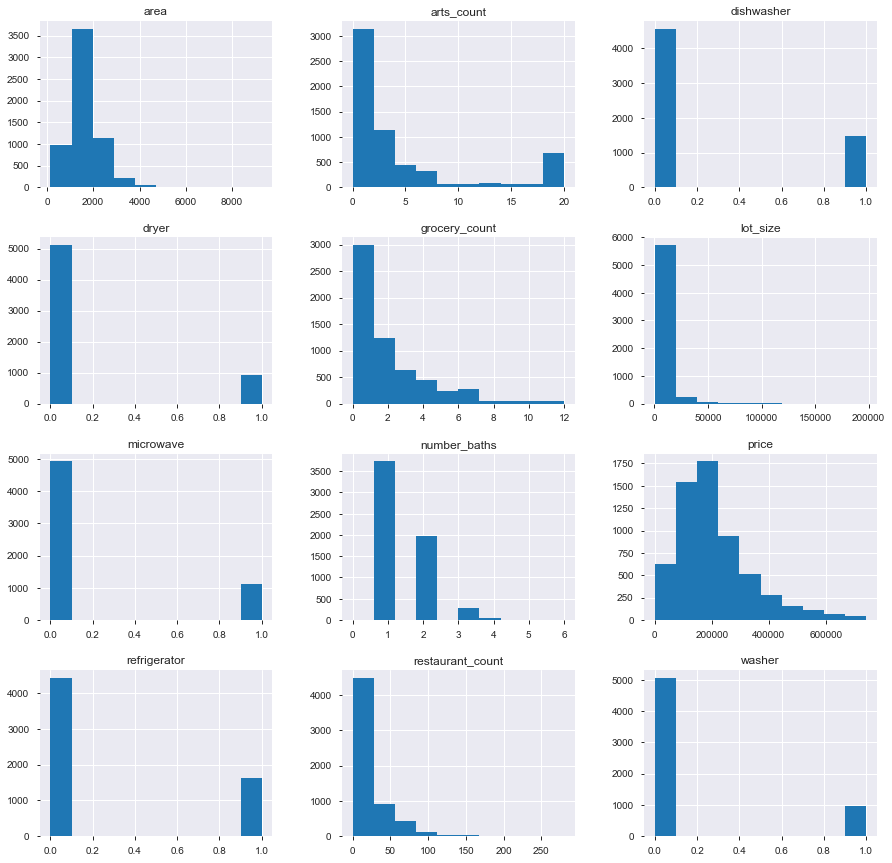

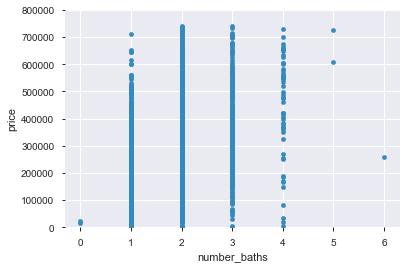

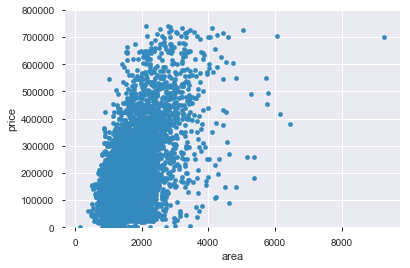

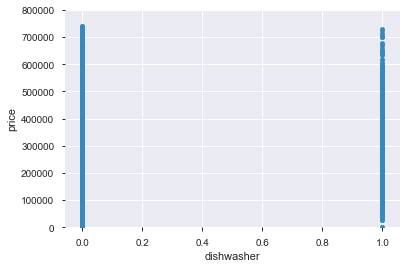

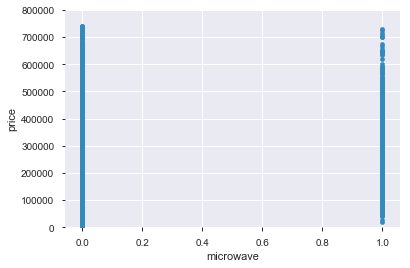

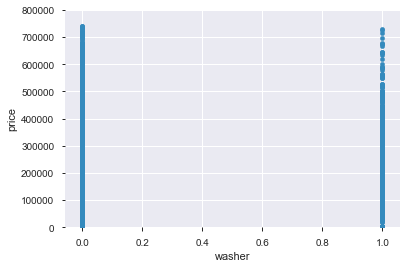

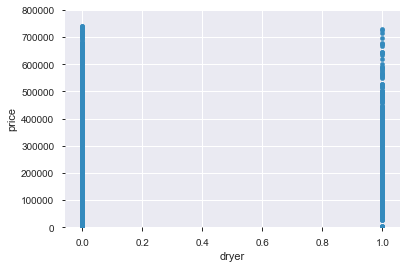

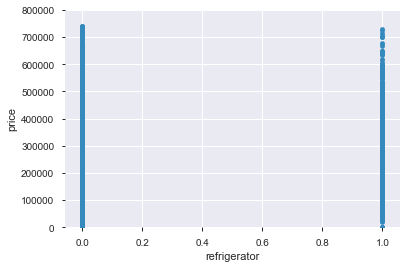

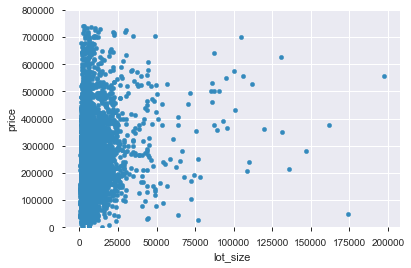

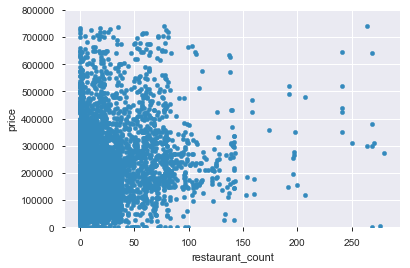

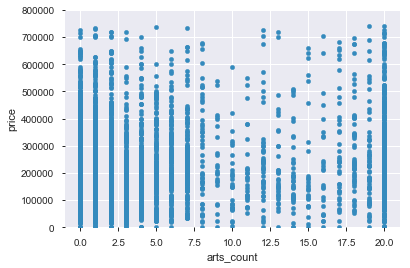

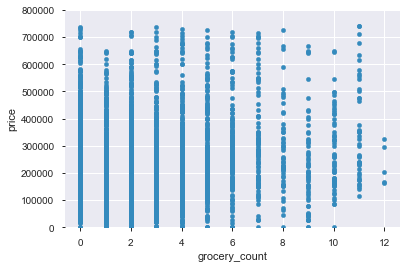

In [249]:

color = sns.color_palette()

def getdf(path):
    train_df = pd.read_csv(path)
    train_df = train_df.replace('None', np.nan)
    train_df = train_df.replace('Unknown', np.nan)
    return train_df
    

# display plot of numerical features that has high skewness
def skewIndex(df):
    features = df[df.columns].skew(axis = 0, skipna = True)
    high_skewness = features[features > 0.5]
    skew_index = high_skewness.index
    return skew_index


def getDescription(df):
    skew_index = skewIndex(df)
    for c in skew_index:
        print("\n")
        print("-------------------------")
        print(c, "statics:")
        print(df[c].describe()) 
    sn.distplot(train_df["price"])
    print("Skewness: %f" % train_df["price"].skew())
    print("Kurtosis: %f" % train_df["price"].kurt())
    

train_df = getdf("data_eda.csv")
getDescription(train_df)


def plot(df):
    skew_index = skewIndex(df)
    train_df[skew_index].hist(figsize=(15,15))
    for i in range(len(skew_index)):
        #scatter plot
        
        var = skew_index[i]
        
        if var == "price":
            continue 
        data = pd.concat([train_df['price'], train_df[var]], axis=1)
        data.plot.scatter(x=var, y='price', ylim=(0,800000))
%matplotlib inline
plot(train_df)

Then, let's take a look at the correlations between features and sold price.

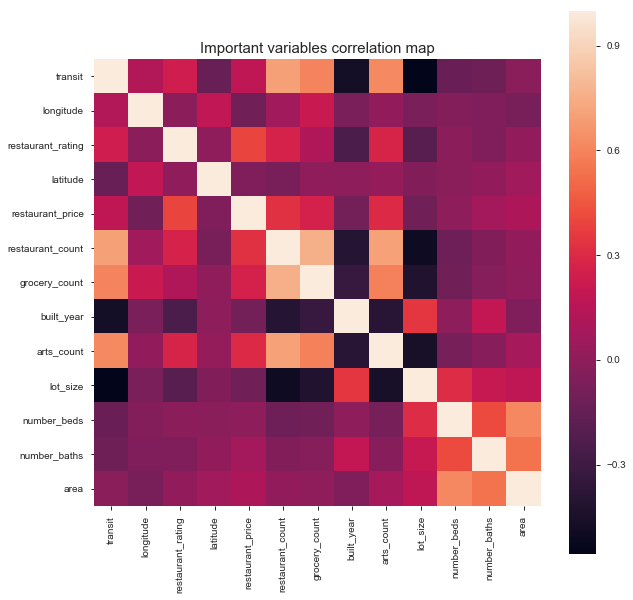

In [250]:
corr_df_sel = corr_df.ix[(corr_df['corr_values']>0.02) | (corr_df['corr_values'] < -0.01)]
# corr_df_sel

cols_to_use = corr_df_sel.col_labels.tolist()

temp_df = df[cols_to_use]
corrmat = temp_df.corr(method='spearman')
f, ax = plt.subplots(figsize=(10, 10))

# Draw the heatmap using seaborn
sns.heatmap(corrmat, vmax=1., square=True)
plt.title("Important variables correlation map", fontsize=15)
plt.show()

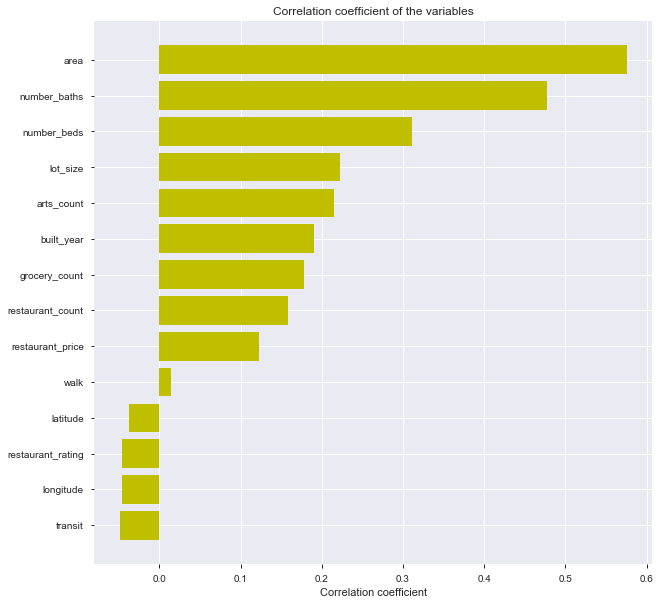

In [251]:
color = sns.color_palette()
cols = [col for col in df.columns if col not in ['price'] if df[col].dtype=='float64' or df[col].dtype=='int64']

labels = []
values = []
for col in cols:
    labels.append(col)
    values.append(np.corrcoef(df[col].values, df.price.values)[0,1])
corr_df = pd.DataFrame({'col_labels':labels, 'corr_values':values})
corr_df = corr_df.sort_values(by='corr_values')
    
ind = np.arange(len(labels))
width = 0.9
fig, ax = plt.subplots(figsize=(10,10))
rects = ax.barh(ind, np.array(corr_df.corr_values.values), color='y')
ax.set_yticks(ind)
ax.set_yticklabels(corr_df.col_labels.values, rotation='horizontal')
ax.set_xlabel("Correlation coefficient")
ax.set_title("Correlation coefficient of the variables")
plt.show()

As shown in above correlation coefficient plot, we can overserva relatively high correlations between area, number of bedroom, number of bathroom and sold price. We will take a closer look at the correlation between each two variables.

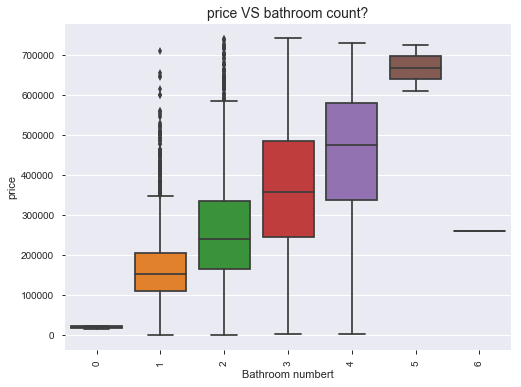

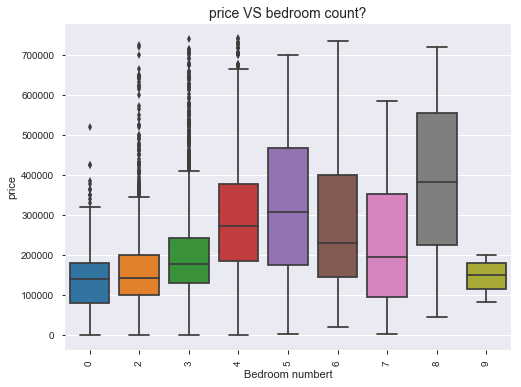

In [252]:
plt.figure(figsize=(8,6))
sns.boxplot(x="number_baths", y="price", data=df)
plt.ylabel('price', fontsize=11)
plt.xlabel('Bathroom numbert', fontsize=11)
plt.xticks(rotation='vertical')
plt.title("price VS bathroom count?", fontsize=14)
plt.show()


plt.figure(figsize=(8,6))
sns.boxplot(x="number_beds", y="price", data=df)
plt.ylabel('price', fontsize=11)
plt.xlabel('Bedroom numbert', fontsize=11)
plt.xticks(rotation='vertical')
plt.title("price VS bedroom count?", fontsize=14)
plt.show()

From above box plot, we can conclude that the property with more bathroom number tends to has higher property value. 

<Figure size 864x864 with 0 Axes>

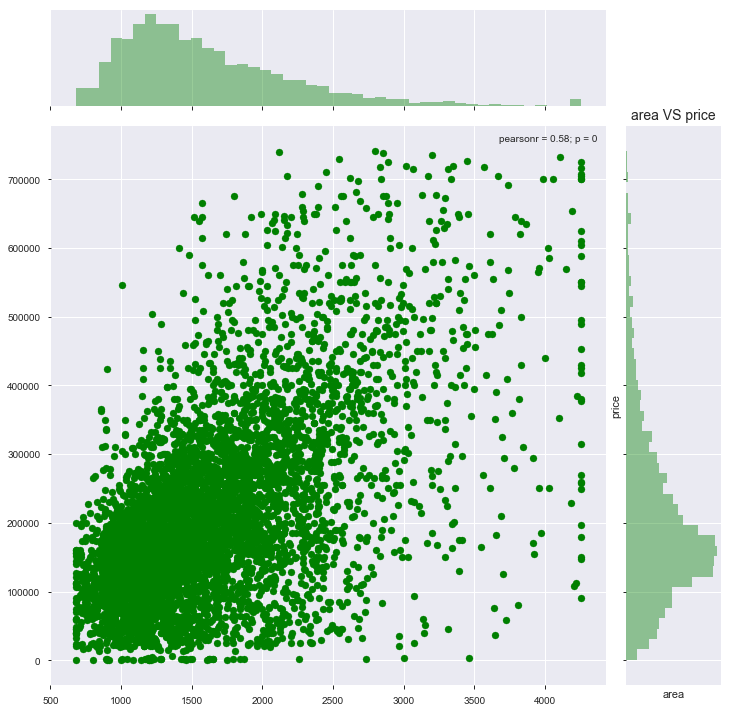

In [253]:
col = "area"
ulimit = np.percentile(df[col].values, 99.5)
llimit = np.percentile(df[col].values, 0.5)
df[col].ix[df[col]>ulimit] = ulimit
df[col].ix[df[col]<llimit] = llimit

plt.figure(figsize=(12,12))
sns.jointplot(x=df['area'].values, y=df['price'].values, size=10, color='g')
plt.ylabel('price', fontsize=11)
plt.xlabel('area', fontsize=11)
plt.title("area VS price", fontsize=14)
plt.show()

From above histgram and scatter plot, we can find that there is a positve correlation between building area and property value.

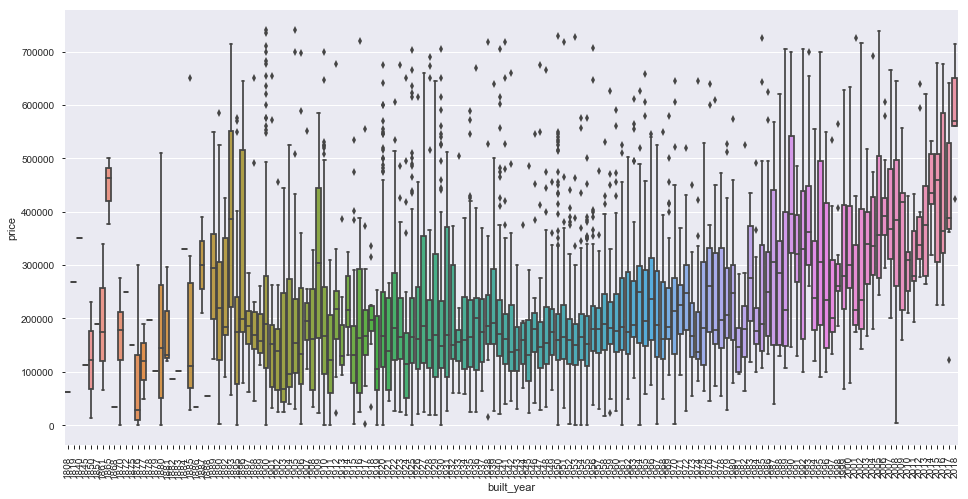

In [254]:
var = 'built_year'
data = pd.concat([df['price'], df[var]], axis=1)
f, ax = plt.subplots(figsize=(16, 8))
fig = sns.boxplot(x=var, y="price", data=data)
plt.xticks(rotation=90);

A minor increasing trend can be observed between property value and built in year.

## Data Preprocessing

#### Price Distribution Analysis
reference: https://brianmusisi.com/design/Predicting+House+Prices-2.html

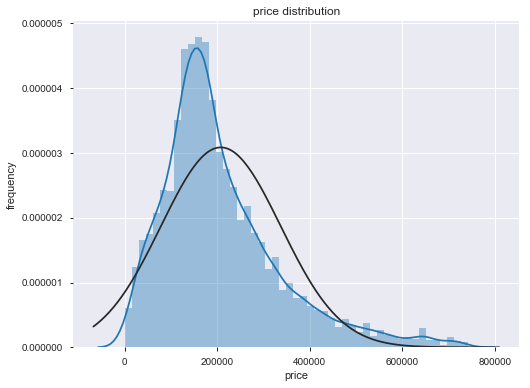

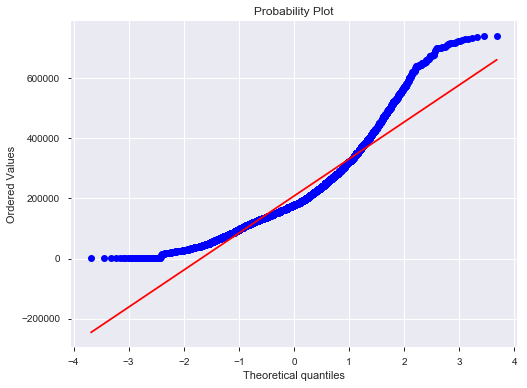

Skewness: 1.3060465986875844
Kurtosis: 2.034539072985852


In [255]:
fig = plt.figure(figsize=(8, 6))
sns.distplot(df['price'], fit=norm)
plt.ylabel('frequency')
plt.title('price distribution')

fig = plt.figure(figsize=(8, 6))
stats.probplot(df['price'], plot = plt)
plt.show()

print("Skewness: " + str(df["price"].skew()))
print("Kurtosis: " + str(df["price"].kurt()))

From the above analysis, we can conclude that the houses prices are skewed. In linear model, one assumption is that training sample has the similar distribution with the real data. Also, normalizing data usually benefits the performance of the model. We decided to normalize the price data first. We applied `log transformation` to the price by adding a constant `88000` and then using `np.log1p` and stored the data in a new column named `price_t`

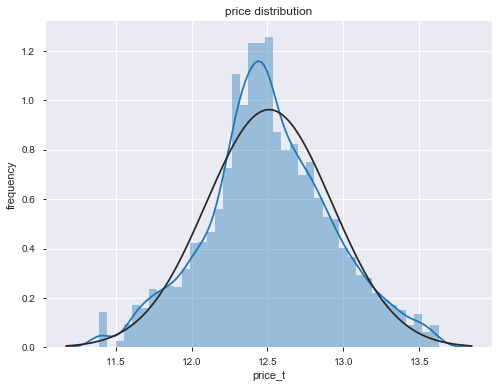

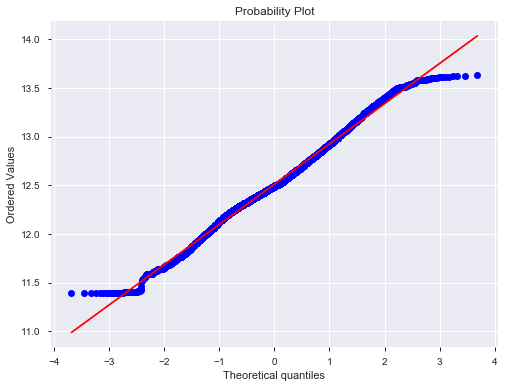

Skewness: 0.056472196209008146
Kurtosis: 0.055661974803026926


In [256]:
df['price_t'] = np.log1p(df["price"] + 88000)
fig = plt.figure(figsize=(8, 6))
sns.distplot(df['price_t'],fit=norm)
plt.ylabel('frequency')
plt.title('price distribution')

fig = plt.figure(figsize=(8, 6))
stats.probplot(df["price_t"], plot=plt)
plt.show()

print("Skewness: " + str(df["price_t"].skew()))
print("Kurtosis: " + str(df["price_t"].kurt()))

Then we will examine other features' skewness. We only focus on the columns whose `dtype` is float or int and has not been normalized before. 

In [257]:
feature_examination = ["lot_size", "restaurant_count", 'area', 'arts_count', 'walk',
                       'grocery_count', 'number_baths', 'number_beds',
                       'restaurant_rating', 'restaurant_price', 'transit' ]
feature_skewness = {}
for i in feature_examination:
    feature_skewness[i] = skew(df[i])
s = pd.DataFrame.from_dict(feature_skewness, orient='index')
s

,0
lot_size,6.970161
restaurant_count,3.209055
area,1.356159
arts_count,1.707064
walk,0.177002
grocery_count,1.669556
number_baths,1.364899
number_beds,0.204227
restaurant_rating,-2.458642
restaurant_price,-1.340235


Above are the features with their skewnesses. We then used `Box Cox Transformation` to normalize them. We chose features whose skewness larger than 1 or less than -1. We used the `lambda` that maximizes the `log-likelihood` for the function. Since some features contain 0, we can not use the default method to choose lambda. We set lambda to be 0.15 according to another [house price prediction project](https://brianmusisi.com/design/Predicting+House+Prices-2.html).

In [152]:
s_1 = s[(s[0] > 1 )]
res = list(s_1.index)
new = []
df = df[df['area'] > 0]
for i in res:
    new_column = i + "_t"
    new.append(new_column)
    df[new_column] = boxcox1p(df[i], 0.1)
s_n1 = s[(s[0] < -1 )]
res_n = list(s_n1.index)
for i in res_n:
    new_column = i + "_t"
    new.append(new_column)
    df[new_column] = boxcox1p(df[i], 3)

In [153]:
feature_skewness_new = {}
for i in new:
    feature_skewness_new[i] = skew(df[i])
s_new = pd.DataFrame.from_dict(feature_skewness_new, orient='index')
s_new

,0
lot_size_t,0.356158
restaurant_count_t,-0.063057
area_t,0.447124
arts_count_t,0.770425
grocery_count_t,0.281307
number_baths_t,0.923894
restaurant_rating_t,-0.631014
restaurant_price_t,0.516517


The `Box Cox Transformation` makes the features more normalized.

In [163]:
drop_list = ["price","lot_size", "restaurant_count", "area","arts_count",
             "grocery_count", "number_baths","restaurant_rating",
             "restaurant_price"]
df_model = df.drop(drop_list, axis = 1)
df_model

,number_beds,dishwasher,microwave,washer,dryer,refrigerator,building_type,built_year,heating_system,cooling_system,...,transit,price_t,lot_size_t,restaurant_count_t,area_t,arts_count_t,grocery_count_t,number_baths_t,restaurant_rating_t,restaurant_price_t
0,3,1,1,0,0,1,Townhouse,2008,Forced Air,Central,...,69,12.629708,13.284717,3.195079,11.109463,0.717735,0.717735,1.161232,30.041667,4.186618
1,3,0,0,0,0,0,Single Family Home,1950,Other,Central,...,27,12.563751,14.855876,1.161232,10.374939,0.717735,0.000000,0.717735,35.390625,2.333333
2,3,0,0,1,1,1,Single Family Home,1920,Other,None,...,34,12.495008,13.437198,3.622044,11.051071,1.746189,1.161232,0.717735,40.095792,4.068370
3,3,0,0,0,0,0,Single Family Home,1940,Other,Wall,...,42,12.061053,14.718583,4.097307,10.744771,1.486984,1.161232,0.717735,34.274333,3.548543
4,3,0,0,0,0,0,Single Family Home,1950,Other,Central,...,69,12.295003,13.095013,3.682731,10.617640,0.000000,0.717735,1.161232,41.333333,3.463542
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6039,3,0,0,0,0,0,Single Family Home,1955,Other,Central,...,0,12.931205,17.206192,2.148140,10.741958,0.717735,0.000000,0.717735,52.642168,8.666667
6040,3,0,0,0,0,0,Single Family Home,1900,Other,Central,...,40,12.421188,13.875101,4.269436,11.016325,1.486984,1.161232,0.717735,24.806297,3.389579
6041,3,1,1,1,1,1,Single Family Home,1950,Forced Air,Central,...,35,13.021440,15.110311,3.492828,11.240314,0.717735,1.746189,0.717735,22.728921,4.342764
6042,3,1,1,1,1,1,Single Family Home,1972,Forced Air,Central,...,21,12.581082,14.732480,3.020055,10.983590,0.000000,1.161232,1.161232,22.899920,4.638295


For the categorical data, we also need to transfer them into numerical. Here, we use `label encoder` from sklearn. It will encode target labels with value between 0 and n_classes-1.

In [164]:
from sklearn.preprocessing import LabelEncoder
numerics = ['int64', 'float64']
df_num = df_model.select_dtypes(include = numerics)
df_cat = df_model.select_dtypes(include = "object")

df_process = pd.DataFrame()

# For each categorical column
# We fit a label encoder, transform our column and 
# add it to our new dataframe
label_encoders = {}
for col in df_cat.columns:
    print("Encoding " + col)
    new_label = LabelEncoder()
    df_process[col] = new_label.fit_transform(df_model[col])
    label_encoders[col] = new_label

df_model_label = pd.concat([df_num, df_process], axis = 1)
df_model_label.info()

Encoding dishwasher
Encoding microwave
Encoding washer
Encoding dryer
Encoding refrigerator
Encoding building_type
Encoding heating_system
Encoding cooling_system
Encoding parking
Encoding stories
Encoding postcode
<class 'pandas.core.frame.DataFrame'>
Int64Index: 6044 entries, 0 to 6043
Data columns (total 26 columns):
number_beds            6044 non-null int64
built_year             6044 non-null int64
latitude               6044 non-null float64
longitude              6044 non-null float64
walk                   6044 non-null float64
transit                6044 non-null int64
price_t                6044 non-null float64
lot_size_t             6044 non-null float64
restaurant_count_t     6044 non-null float64
area_t                 6044 non-null float64
arts_count_t           6044 non-null float64
grocery_count_t        6044 non-null float64
number_baths_t         6044 non-null float64
restaurant_rating_t    6044 non-null float64
restaurant_price_t     6044 non-null float64
dishwashe

#### Training and Testing Dataset

The last thing we need to do is to split our dataset into training and testing dataset. In this project, we will use 30% of the data to be our testing dataset and 70% of them to be used for trainging.

In [182]:
# We shuffled the dataset when we did tehe project, but we do not want it to be ran again,
# so we removed code away.

train, test = train_test_split(df_model_label, test_size=0.25)
train.reset_index(inplace = True, drop = True)
test.reset_index(inplace = True, drop = True)
train.head()

,number_beds,built_year,latitude,longitude,walk,transit,price_t,lot_size_t,restaurant_count_t,area_t,...,microwave,washer,dryer,refrigerator,building_type,heating_system,cooling_system,parking,stories,postcode
0,2,1925,40.384598,-80.037476,46.0,47,12.470362,12.483533,4.727334,10.338289,...,0,0,0,0,2,8,0,27,1,15
1,2,1900,40.455494,-80.000620,88.0,71,11.798112,13.868348,5.518456,10.238715,...,0,0,0,0,2,1,6,27,2,11
2,2,1978,40.454132,-79.718280,6.0,0,12.292255,10.145532,2.709816,10.695046,...,0,0,0,0,3,8,0,0,1,36
3,2,1920,40.427180,-80.013870,62.0,65,12.078245,11.385761,4.097307,10.809900,...,0,0,0,0,2,7,6,27,5,10
4,0,1935,40.454613,-79.925540,92.0,70,12.468441,9.831655,5.271613,9.831655,...,0,0,0,1,0,8,6,28,0,5


## Predictive Model

We will use the training dataset that we generated above for training model. The model we built is based on the idea of ensembling. We first explored existing house price prediction models by searching related projects online. From the popular models that we collected, we selected 4 of the ensemble-based methods and used as the base model. We then built a lightGBM model on the second-level, which uses the results of the four base predictors at the first-level.

The four base predictor we used are: 
  
    * Voting Regressor
    * Random Forest Regressor  
    * Extra trees Regressor  
    * Adaboost Regress

<img src="./img/ensemble.jpeg" alt="Drawing" style="width: 600px;"/>

Now let's have a look at the heatmap showing the corrleations between the features.

In [183]:
# code modified from https://www.kaggle.com/flennerhag/ml-ensemble-scikit-learn-style-ensemble-learning#4.-Ensemble-learning
plt.figure(figsize=(23,23))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(train.corr(),linewidths=0.1,
            square=True, cmap=plt.cm.RdBu, linecolor='black', annot=True)

First, we set up the parameters for the four base models.

In [184]:
# Random Forest Regressor
rf_params = {
    'n_jobs': -1,
    'n_estimators': 1000,
    'max_depth': 7,
    'min_samples_leaf': 2,
    'max_features' : 'auto'
}

# Extra Trees Regressor
et_params = {
    'n_jobs': -1,
    'n_estimators':1000,
    'max_depth': 7,
    'min_samples_leaf': 2,
    'max_features' : 'auto'
}

# AdaBoost Regressor
ada_params = {
    'n_estimators': 1000,
    'learning_rate' : 0.01
}

# Gradient Boost Regressor
gb_params = {
    'n_estimators': 1000,
    'subsample': 0.9,
    'max_depth': 7,
    'min_samples_leaf': 2
}

With the help from https://www.kaggle.com/arthurtok/introduction-to-ensembling-stacking-in-python#Ensembling-&-Stacking-models, we built a helper class that extends the inbuilt methods of the Sklearn regressor we used in this project. It helped us avoid writing the same methods for 4 times or even longer.


In [185]:
# source:https://www.kaggle.com/arthurtok/introduction-to-ensembling-stacking-in-python#Ensembling-&-Stacking-models
class SklearnHelper(object):
    def __init__(self, model, seed=0, params=None):
        params['random_state'] = seed
        self.model = model(**params)

    def train(self, x_train, y_train):
        self.model.fit(x_train, y_train)

    def predict(self, x):
        return self.model.predict(x)
    
    def fit(self,x,y):
        return self.model.fit(x,y)
    
    def feature_importances(self,x,y):
        print(self.model.fit(x,y).feature_importances_)

Before trainging the data, we need to create `train_x` as training features and `train_y` as training labels. Also, since we used the utility function provided in [notebook](https://www.kaggle.com/arthurtok/introduction-to-ensembling-stacking-in-python#Ensembling-&-Stacking-models), we transfer `train_x` and `test_x` to `ndarray` as it required. 

In [186]:
train_y = train['price_t']
train_x = train.drop(['price_t'], axis=1)
test_y = test['price_t']
test_x = test.drop(['price_t'], axis=1)
train_x = np.array(train_x)
test_x = np.array(test_x)

Now we can build 4 models. Our model uses the putput of base classifiers as input of the second-level model. It is better if we can divide the training dataset into 4 folds to avoid overfitting. The functions below uses methods suggested in [notebook](https://www.kaggle.com/arthurtok/introduction-to-ensembling-stacking-in-python#Ensembling-&-Stacking-models)

In [187]:
num_train = len(train)
num_test = len(test)

rf = SklearnHelper(model=RandomForestRegressor, seed=0, params = rf_params)
et = SklearnHelper(model=AdaBoostRegressor, seed=0, params = ada_params)
ada = SklearnHelper(model=GradientBoostingRegressor, seed=0, params = gb_params)
gb = SklearnHelper(model=ExtraTreesRegressor, seed=0, params = et_params)

In [188]:
def k_train(model, x_train, y_train, x_test):
    train = np.zeros((num_train,))
    test = np.zeros((num_test,))
    test_k = np.empty((4, num_test))
    
    kf = KFold(num_train, n_folds= 4, random_state=0)
    for i, (train_index, test_index) in enumerate(kf):

        x_t = x_train[train_index]
        y_t = y_train[train_index]

        x_te = x_train[test_index]

        model.train(x_t, y_t)

        train[test_index] = model.predict(x_te)
        test_k[i, :] = model.predict(x_test)

    test[:] = test_k.mean(axis=0)
    return train.reshape(-1, 1), test.reshape(-1, 1)

In [189]:
# Create our OOF train and test predictions. These base results will be used as new features
et_train, et_test = k_train(et, train_x, train_y, test_x) # Extra Trees
print("finish extra trees")
rf_train, rf_test = k_train(rf,train_x, train_y, test_x) # Random Forest
print("finish random forest")
ada_train, ada_test = k_train(ada, train_x, train_y, test_x) # AdaBoost 
print("finish adaboost")
gb_train, gb_test = k_train(gb,train_x, train_y, test_x) # Gradient Boost
print("finish gradient boost")

finish extra trees
finish random forest
finish adaboost
finish gradient boost


## Feature Importances

In [190]:
rf_feature = rf.feature_importances(train_x,train_y)
et_feature = et.feature_importances(train_x, train_y)
ada_feature = ada.feature_importances(train_x, train_y)
gb_feature = gb.feature_importances(train_x,train_y)
print(rf_feature)

[4.54393205e-03 7.86411516e-02 2.58180913e-02 8.21315408e-02
 2.33050616e-02 1.40878117e-02 3.86517214e-02 1.86819127e-02
 4.40042405e-01 5.21184442e-02 1.75462583e-02 1.18460965e-02
 8.14912747e-03 4.59495500e-02 2.82304613e-03 1.11944069e-03
 5.56951849e-04 5.60866270e-04 3.91686034e-04 5.72070395e-03
 5.95625838e-03 8.84758444e-02 3.16349473e-03 1.72876523e-03
 2.79898376e-02]
[3.91555615e-04 1.07384190e-01 3.48830365e-03 6.04797583e-02
 1.04464645e-02 7.21254220e-03 3.96579619e-02 1.30403476e-02
 3.92152586e-01 5.01377612e-02 2.46944804e-02 6.12405469e-02
 1.03570750e-03 4.90651326e-02 1.05089241e-02 8.39346919e-03
 7.81832611e-03 5.23133699e-03 4.01225321e-05 1.28727575e-02
 7.34905473e-04 1.12081872e-01 1.07820636e-03 6.15602962e-03
 1.46567116e-02]
[0.01511274 0.06657436 0.12958265 0.13869903 0.06925188 0.05118747
 0.09487444 0.04744122 0.12031446 0.01861506 0.01744254 0.0099964
 0.05634753 0.04406977 0.00500808 0.00284636 0.00257846 0.00235438
 0.00580068 0.00450656 0.02732712 

In [191]:
rf_feature = [4.52158674e-03,7.64134556e-02,2.61640801e-02,8.15664918e-02,
              2.11066467e-02,1.03792748e-02,3.79408396e-02,1.79405198e-02,
              4.36974195e-01,4.17593903e-02,1.94860800e-02,1.23580171e-02,
              7.96079350e-03,5.84109567e-02,2.40779393e-03,1.36511318e-03,
              3.56570501e-04,2.98341263e-04,5.65451478e-04,5.95093209e-03,
              4.88584809e-03,9.03332379e-02,2.76553223e-03,1.57968050e-03,
              3.65091711e-02]
et_feature = [9.62476564e-04,1.01007865e-01,8.07794820e-03,4.54525396e-02,
              3.60118968e-03,1.63143924e-03,3.10994579e-02,2.30151619e-02,
              4.12820815e-01,3.94423810e-02,1.69292880e-02,4.65838034e-02,
              2.80368272e-03,6.30150661e-02,2.76426807e-02,9.83603976e-03,
              7.22998419e-03,5.95944597e-03,8.95066691e-05,1.04661769e-02,
              1.87307475e-03,1.17996939e-01,1.80878903e-03,2.15503555e-03,
              1.84992125e-02]
ada_feature = [0.01424421,0.0665479,0.12907858,0.13272909,0.0645828,
               0.05124307,0.09418432,0.05147204,0.12862256,0.02011813,
               0.01717681,0.01121615,0.05395952,0.04655981,0.00474344,
               0.00329752,0.0024825,0.00250899,0.00595512,0.00406292,
               0.02573248,0.01218337,0.01375329,0.02052385,0.02302154]
gb_feature = [0.03372039,0.04139361,0.01562614,0.03445772,0.01262616,
              0.00948461,0.02323761,0.01194205,0.30467129,0.05419811,
              0.03116018,0.20007032,0.00280088,0.02633729,0.03027627,
              0.00368411,0.00182132,0.00155612,0.0009117,0.01510943,
              0.00659559,0.10958028,0.00368778,0.00252866,0.0225224,]

The following code is adapted from [notebook](https://www.kaggle.com/arthurtok/introduction-to-ensembling-stacking-in-python#Ensembling-&-Stacking-models). It shows the importance of features in different base models.

In [196]:
cols = train.drop("price_t",axis = 1).columns.values
feature_dataframe = pd.DataFrame({'features': cols,
     'Random Forest feature importances': rf_feature,
     'Extra Trees  feature importances': et_feature,
      'AdaBoost feature importances': ada_feature,
    'Gradient Boost feature importances': gb_feature})
feature_dataframe["average"] = 0.25 * (
    feature_dataframe["Random Forest feature importances"]+
    feature_dataframe["Extra Trees  feature importances"]+
    feature_dataframe["AdaBoost feature importances"]+
    feature_dataframe["Gradient Boost feature importances"])
feature_dataframe.sort_values("average",ascending = False)

,features,Random Forest feature importances,Extra Trees feature importances,AdaBoost feature importances,Gradient Boost feature importances,average
8,area_t,0.436974,0.412821,0.128623,0.304671,0.320772
21,cooling_system,0.090333,0.117997,0.012183,0.109580,0.082523
3,longitude,0.081566,0.045453,0.132729,0.034458,0.073551
1,built_year,0.076413,0.101008,0.066548,0.041394,0.071341
11,number_baths_t,0.012358,0.046584,0.011216,0.200070,0.067557
13,restaurant_price_t,0.058411,0.063015,0.046560,0.026337,0.048581
6,lot_size_t,0.037941,0.031099,0.094184,0.023238,0.046616
2,latitude,0.026164,0.008078,0.129079,0.015626,0.044737
9,arts_count_t,0.041759,0.039442,0.020118,0.054198,0.038880
7,restaurant_count_t,0.017941,0.023015,0.051472,0.011942,0.026092


In [197]:
#source: source:https://www.kaggle.com/arthurtok/introduction-to-ensembling-stacking-in-python#Ensembling-&-Stacking-models
trace = go.Scatter(
    y = feature_dataframe['Random Forest feature importances'].values,
    x = feature_dataframe['features'].values,
    mode='markers',
    marker=dict(
        sizemode = 'diameter',
        sizeref = 1,
        size = 25,
        color = feature_dataframe['Random Forest feature importances'].values,
        colorscale='Portland',
        showscale=True
    ),
    text = feature_dataframe['features'].values
)
data = [trace]

layout= go.Layout(
    autosize= True,
    title= 'Random Forest Feature Importance',
    hovermode= 'closest',
    yaxis=dict(
        title= 'Feature Importance',
        ticklen= 5,
        gridwidth= 2
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig,filename='scatter2010')

trace = go.Scatter(
    y = feature_dataframe['Extra Trees  feature importances'].values,
    x = feature_dataframe['features'].values,
    mode='markers',
    marker=dict(
        sizemode = 'diameter',
        sizeref = 1,
        size = 25,
        color = feature_dataframe['Extra Trees  feature importances'].values,
        colorscale='Portland',
        showscale=True
    ),
    text = feature_dataframe['features'].values
)
data = [trace]

layout= go.Layout(
    autosize= True,
    title= 'Extra Trees Feature Importance',
    hovermode= 'closest',
    yaxis=dict(
        title= 'Feature Importance',
        ticklen= 5,
        gridwidth= 2
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig,filename='scatter2010')

trace = go.Scatter(
    y = feature_dataframe['AdaBoost feature importances'].values,
    x = feature_dataframe['features'].values,
    mode='markers',
    marker=dict(
        sizemode = 'diameter',
        sizeref = 1,
        size = 25,
        color = feature_dataframe['AdaBoost feature importances'].values,
        colorscale='Portland',
        showscale=True
    ),
    text = feature_dataframe['features'].values
)
data = [trace]

layout= go.Layout(
    autosize= True,
    title= 'AdaBoost Feature Importance',
    hovermode= 'closest',
    yaxis=dict(
        title= 'Feature Importance',
        ticklen= 5,
        gridwidth= 2
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig,filename='scatter2010')

trace = go.Scatter(
    y = feature_dataframe['Gradient Boost feature importances'].values,
    x = feature_dataframe['features'].values,
    mode='markers',
    marker=dict(
        sizemode = 'diameter',
        sizeref = 1,
        size = 25,
        color = feature_dataframe['Gradient Boost feature importances'].values,
        colorscale='Portland',
        showscale=True
    ),
    text = feature_dataframe['features'].values
)
data = [trace]

layout= go.Layout(
    autosize= True,
    title= 'Gradient Boosting Feature Importance',
    hovermode= 'closest',
    yaxis=dict(
        title= 'Feature Importance',
        ticklen= 5,
        gridwidth= 2
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig,filename='scatter2010')

,features,Random Forest feature importances,Extra Trees feature importances,AdaBoost feature importances,Gradient Boost feature importances,average
8,area_t,0.436974,0.412821,0.128623,0.304671,0.320772
21,cooling_system,0.090333,0.117997,0.012183,0.109580,0.082523
3,longitude,0.081566,0.045453,0.132729,0.034458,0.073551
1,built_year,0.076413,0.101008,0.066548,0.041394,0.071341
11,number_baths_t,0.012358,0.046584,0.011216,0.200070,0.067557
13,restaurant_price_t,0.058411,0.063015,0.046560,0.026337,0.048581
6,lot_size_t,0.037941,0.031099,0.094184,0.023238,0.046616
2,latitude,0.026164,0.008078,0.129079,0.015626,0.044737
9,arts_count_t,0.041759,0.039442,0.020118,0.054198,0.038880
7,restaurant_count_t,0.017941,0.023015,0.051472,0.011942,0.026092


We can conclude that the most important features are:  
`area  `  
`cooling system  `   
`longitude  `  
`built year  `  
`number of bathrooms  `  
`neighborhood restaurant average price  `  
`lot size  `  
`latitude  `  

The 4 base models have similar output, here is the intermediate output of the model.

In [198]:
base_predictions = pd.DataFrame({
    'RandomForest': rf_train.ravel(),
    'ExtraTrees': et_train.ravel(),
    'AdaBoost': ada_train.ravel(),
    'GradientBoost': gb_train.ravel(),
    'ground_truth': train_y
    })
base_predictions.head(10)

,RandomForest,ExtraTrees,AdaBoost,GradientBoost,ground_truth
0,12.428815,12.386223,12.350256,12.454967,12.470362
1,12.256014,12.189615,12.339909,12.323364,11.798112
2,12.385271,12.401522,12.240883,12.419242,12.292255
3,12.295126,12.219756,12.302138,12.231537,12.078245
4,12.422207,12.309129,12.425264,12.469716,12.468441
5,13.015600,12.766596,12.906964,12.977667,13.034627
6,12.660325,12.565484,12.838642,12.511318,13.041155
7,12.103561,12.185586,12.165593,12.188365,12.153468
8,12.375955,12.381061,12.285834,12.402307,12.367345
9,12.387525,12.374604,12.335922,12.415123,12.371591


We will now move to the next level of the model. For the second-level model, the input is the values generated by the base models. And we use lightGBM as the second-level model. The lightGBM model will output our prediction.

In [199]:
train_x_second = np.concatenate((et_train, rf_train, ada_train, gb_train), axis=1)
test_x_second = np.concatenate((et_test, rf_test, ada_test, gb_test), axis=1)

In [200]:
X_half_1 = train_x_second[:int(train_x_second.shape[0] / 2)]
X_half_2 = train_x_second[int(train_x_second.shape[0] / 2):]

y_half_1 = train_y[:int(train_y.shape[0] / 2)]
y_half_2 = train_y[int(train_y.shape[0] / 2):]


d_half_1 = lgb.Dataset(X_half_1, label=y_half_1, free_raw_data=False)
d_half_2 = lgb.Dataset(X_half_2, label=y_half_2, free_raw_data=False)

watchlist_1 = [d_half_1, d_half_2]
watchlist_2 = [d_half_2, d_half_1]

params = {
    "objective": "regression",
    "boosting": "gbdt",
    "num_leaves": 60,
    "learning_rate": 0.0005,
    "feature_fraction": 0.85,
    "reg_lambda": 2,
    "metric": "rmse"
}

print("Building model with first half and validating on second half:")
model_half_1 = lgb.train(params, train_set=d_half_1, num_boost_round=10000, valid_sets=watchlist_1, verbose_eval=200, early_stopping_rounds=200)

print("Building model with second half and validating on first half:")
model_half_2 = lgb.train(params, train_set=d_half_2, num_boost_round=10000, valid_sets=watchlist_2, verbose_eval=200, early_stopping_rounds=200)

Building model with first half and validating on second half:
Training until validation scores don't improve for 200 rounds.
[200]	training's rmse: 0.377662	valid_1's rmse: 0.398758
[400]	training's rmse: 0.355742	valid_1's rmse: 0.377636
[600]	training's rmse: 0.336179	valid_1's rmse: 0.358964
[800]	training's rmse: 0.31909	valid_1's rmse: 0.342926
[1000]	training's rmse: 0.303938	valid_1's rmse: 0.329034
[1200]	training's rmse: 0.290638	valid_1's rmse: 0.317041
[1400]	training's rmse: 0.279047	valid_1's rmse: 0.306916
[1600]	training's rmse: 0.268818	valid_1's rmse: 0.298224
[1800]	training's rmse: 0.259846	valid_1's rmse: 0.2908
[2000]	training's rmse: 0.252028	valid_1's rmse: 0.28458
[2200]	training's rmse: 0.245118	valid_1's rmse: 0.279244
[2400]	training's rmse: 0.239037	valid_1's rmse: 0.274844
[2600]	training's rmse: 0.233668	valid_1's rmse: 0.271053
[2800]	training's rmse: 0.228954	valid_1's rmse: 0.268009
[3000]	training's rmse: 0.224753	valid_1's rmse: 0.26535
[3200]	trainin

Now we can use the model to predict the price in the testing dataset. Since we use`np.log1p` to normalize the price in the pre-processing section, we now use `np.expm1` to show tehe true value. We put the predicted results and the groung truth values in the same dataframe for comparision. 

### Model Evaluation

In [202]:
pred = (np.expm1(model_half_1.predict(test_x_second, num_iteration=model_half_1.best_iteration)) + 88000) / 2
pred += (np.expm1(model_half_2.predict(test_x_second, num_iteration=model_half_2.best_iteration)) + 88000) / 2
ori = np.expm1(test_y) + 88000
res = pd.DataFrame({"ground_truth":ori, "predicted":pred})
res

,ground_truth,predicted
0,337000.0,346288.756194
1,296000.0,311371.230465
2,251000.0,322534.882760
3,318900.0,288777.762792
4,551000.0,579122.319165
...,...,...
1506,576000.0,623133.342046
1507,287500.0,316013.205052
1508,431000.0,411231.648710
1509,416000.0,454362.865047


Now we use MAE to evaluate the accuracy of our model.

In [203]:
res["residual"] = np.abs(res["ground_truth"] - res["predicted"])
res["residual"].mean() / res["ground_truth"].mean()

0.12978273371671536

The `MAE` is about `12%` of the mean value of the testing dataset. It is not perfect but we believe with more careful feature engineeirng and detailed model hyperparameters selection, the model can be improved a lot. 

## Conclusion

This project proposed a new house price prediction model based on the building information as well as the neighborhood information. The model takes the idea of ensemble method. The results are not perfect but have a great opportunity for improvement.

## Limitation and Future Work
Limitation:
1.  Due to the limited time and budget,  we did not get all the information we planned to get at the beginning of the project. For example, we planned to scrape the education resources nearby but all the related APIs were not free and there is no such website that has the information we needed. Another information we did not get is the house price sold last time. During the first time when we scraped the data, we ignored the information. Then we realized the importance of the information, all of us were banned from the website. And there is no enough time for us to find other methods for scraping.
2. The dataset we chose is the houses in Pittsburgh. We chose it because we live in the city and thought we are familiar with the streets and district. However, it is not a good dataset. The features that show great importance in usual cities did not perform the same way in Pittsburgh. We concluded that no features show high correlations with the sold prices except area, number of bathrooms, 

Future work:
1. Seek more reliable data sources and database
2. Integrate more features such as property last sold price,  neighborhood education resource, the crime rate of the community etc.
3. Fine-tuning hyperparameters of the model
4. Apply the model to more  cities or locations

## Reference

1. Pittsburgh property sold list, [link](https://www.trulia.com/sold/Pittsburgh,PA/).
2. Introduction to Ensembling/Stacking in Python, [link](https://www.kaggle.com/arthurtok/introduction-to-ensembling-stacking-in-python/notebook).
3. ML-Ensemble: Scikit-learn style ensemble learning, [link](https://www.kaggle.com/flennerhag/ml-ensemble-scikit-learn-style-ensemble-learning#4.-Ensemble-learning).
4. Simple exploration notebook zillow prize, [link](https://www.kaggle.com/sudalairajkumar/simple-exploration-notebook-zillow-prize).
5. How could you benefit from a box-cox transformation [link](https://blog.minitab.com/blog/applying-statistics-in-quality-projects/how-could-you-benefit-from-a-box-cox-transformation)